In [103]:
from bertopic import BERTopic
import pandas as pd
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech
import matplotlib.pyplot as plt
import seaborn as sns
from utils import clean_traffic


In [104]:

def most_visited_topic_cluster(df,topics_count):
    topic_stats = df.groupby('topic')['traffic_numeric'].agg(['mean', 'median'])
    max = {"mean":0,"topic":None}
    r = range(0,topics_count)
    for i in r:
        element = topic_stats['mean'][i]
        comp = max["mean"]
        if element >= comp:
            max['mean'] = element
            max['topic'] = i
    return max

def max_element(List):
    list_max_element = 0
    for e in List:
        if e > list_max_element:
            list_max_element = e
    return list_max_element

In [105]:
data = pd.read_csv("../preprocssed_data/cleaned_data_USA.csv")    
dataFrame = data[['newsTitle']]
strings_list = [item[0] for item in dataFrame.values.tolist()]


In [106]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(strings_list, show_progress_bar=True)

Batches: 100%|██████████| 94/94 [00:12<00:00,  7.44it/s]


In [107]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

In [108]:
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [109]:
vectorizer_model = CountVectorizer(stop_words="english")

In [ ]:

keybert_model = KeyBERTInspired()

pos_model = PartOfSpeech("en_core_web_sm")

mmr_model = MaximalMarginalRelevance(diversity=0.3)

representation_model = {
    "KeyBERT": keybert_model,
    "MMR": mmr_model,
    "POS": pos_model
}

In [ ]:
topic_model = BERTopic(
embedding_model=embedding_model,
umap_model=umap_model,
hdbscan_model=hdbscan_model,
vectorizer_model=vectorizer_model,
representation_model=representation_model,
top_n_words=10,
verbose=True
)

topics, probs = topic_model.fit_transform(strings_list)

names = topic_model.get_topic_info().Name
topic_model.get_topic_info()

In [ ]:
df = pd.DataFrame({'topic':topics, 'probs':probs})
df['date'] = data[['date']]
df['traffic'] = data[['traffic']]
df['traffic_numeric'] = df['traffic'].apply(clean_traffic)
df


In [ ]:
max = most_visited_topic_cluster(df,max_element(topics))
print(max)

In [ ]:
topic_model.get_topic(max['topic']-1)

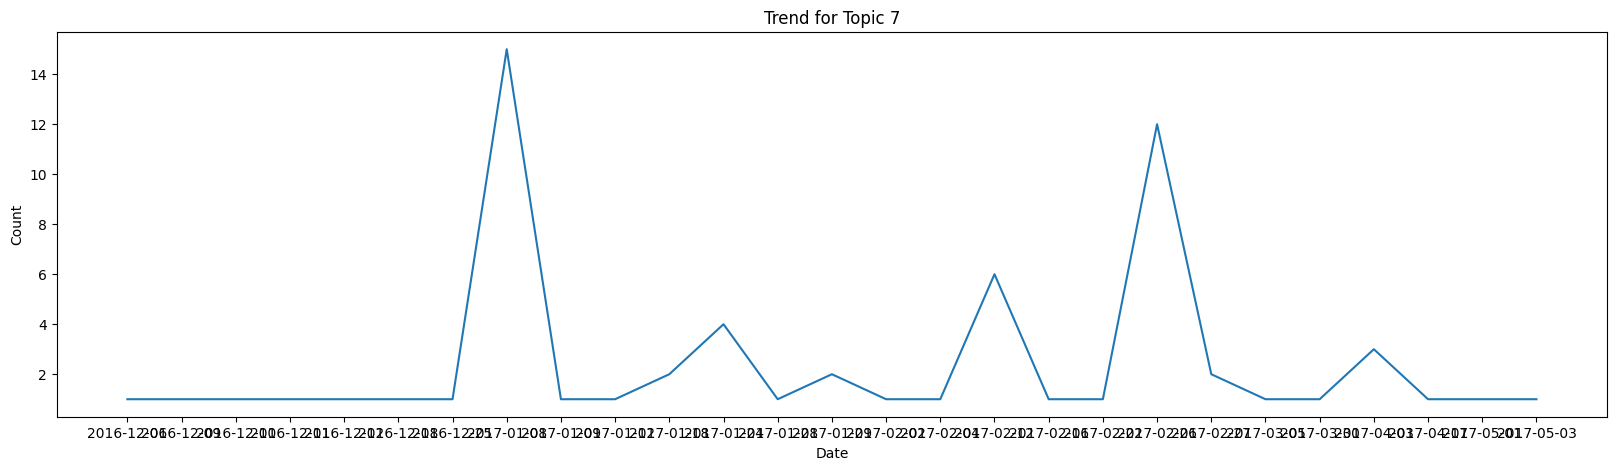

In [119]:

topic_time_distribution = df.groupby(['date', 'topic']).size().reset_index(name='count')
specific_topic = 7
specific_topic_data = topic_time_distribution[topic_time_distribution['topic'] == specific_topic]
plt.figure(figsize=(20, 5))
sns.lineplot(data=specific_topic_data, x='date', y='count')
plt.title(f"Trend for Topic {specific_topic}")
plt.xlabel("Date")
plt.ylabel("Count")
plt.show()



In [ ]:
names

In [118]:
topic_model.visualize_topics()